# Exploration and Curiosity

In Reinforcement Learning (RL), agents learn by maximizing a **reward signal**. This core idea,
often called the _reward hypothesis_, means the design and frequency of rewards heavily influence
how well an agent learns.

However, we often face two major hurdles:
 * **Difficult Reward Design:** Creating informative reward functions (extrinsic rewards from the
   environment) can be complex, especially for intricate tasks.
 * **Sparse Rewards:** Many environments offer rewards only rarely. Imagine a maze where the agent
   only gets a reward (+1) at the exit and zero everywhere else. Without frequent feedback, the
   agent might wander aimlessly or get stuck, failing to explore effectively and find the goal.

When extrinsic rewards are scarce, standard exploration methods (like adding noise to actions) might
not be enough. The agent needs an internal drive to explore novel situations, a form of _curiosity_.
The overall reward is now given by:

$
r_t = e_t + i_t
$

I.e., the sum of the _extrinsic_ reward and an _intrinsic_ component.

This notebook explores [Random Network Distillation (RND)](https://arxiv.org/abs/1810.12894), a
powerful technique that provides the agent with such an intrinsic reward. RND achieved SoTA in
Montezuma's Revenge, a game famously difficult for deep reinforcement learning methods.

**NOTE:** It is highly recommended to read and understand the paper before proceeding with the
notebook.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
from gymnasium.wrappers.vector import RecordEpisodeStatistics

from util.gymnastics import DEVICE, gym_simulation, init_random
from util.rl_algos import BaseAgent, TrajectorySegment, collect_trajectory_segment, \
                          compute_advantages_and_returns, flatten_and_shuffle

## MiniGrid DoorKey Environment

From the [documentation](https://minigrid.farama.org/environments/minigrid/DoorKeyEnv/): "This
environment is difficult, because of the sparse reward, to solve using
classical RL algorithms. It is useful to experiment with curiosity or curriculum learning."

Note that this environment can be solved without
[memory](https://github.com/lcswillems/rl-starter-files/tree/317da04a9a6fb26506bbd7f6c7c7e10fc0de86e0?tab=readme-ov-file#add-memory),
though I encourage you to explore Lucas Willems’ starter-files repo and memory-based solutions.

**Something to think about:**
Consider the Markovian property and partial observability of the state... In particular, how does
the agent know if they have the key? They don't! They learnt a policy of states highly-likely to
have a key, if they don't they go explore more. They may be learning that staying close to a wall
means we have the key...

In [3]:
MINIGRID_ENV       = "MiniGrid-DoorKey-5x5-v0"
MINIGRID_ENV_8x8   = "MiniGrid-DoorKey-8x8-v0"
MINIGRID_ENV_16x16 = "MiniGrid-DoorKey-16x16-v0"

MoviePy - Building file /tmp/rl-video.gif with imageio.


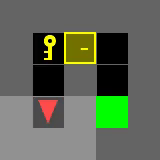

In [4]:
# Simulation of the environment, to verify it loaded.
# https://minigrid.farama.org/environments/minigrid/DoorKeyEnv/#
gym_simulation(MINIGRID_ENV)

### Environment Wrappers

To simplify our training, we only use simplified image observations.

In [3]:
sample_state, _ = init_random(gym.make(MINIGRID_ENV)).reset()

print(sample_state['image'].shape)
print(sample_state['direction'])
print(sample_state['mission'])

(7, 7, 3)
1
use the key to open the door and then get to the goal


In [5]:
def minigrid_wrapper(env: gym.Env) -> gym.Env:
    # Converts to image observations
    env = ImgObsWrapper(env)
    return env

In [5]:
sample_state, _ = minigrid_wrapper(gym.make(MINIGRID_ENV)).reset()
print(sample_state.shape)

(7, 7, 3)


In [6]:
def make_minigrid_env(minigrid_env=MINIGRID_ENV, num_envs=32) -> gym.vector.VectorEnv:
    """Utility function to create a MiniGrid vectorized environment with the appropriate wrappers"""
    env = gym.make_vec(minigrid_env, num_envs=num_envs, wrappers=[minigrid_wrapper])
    env = RecordEpisodeStatistics(env)
    return env

## A2C Algorithm

We already implemented a simplified A2C algorithm in the actor-critic notebook. We will now power-up
the A2C implementation using a vectorized environment and utilities previously introduced in the PPO
notebook. We then will extend the implementation with RND, let's start!

### Training Loop

In [7]:
def train(env: gym.vector.VectorEnv, agent: BaseAgent, rollout_size=16,
          log_every = 100, solved_score=0.95):
    """The A2C training loop."""
    n_step = 0
    avg_score = 0.0
    obs, _ = env.reset()
    obs    = torch.Tensor(obs).to(DEVICE)
    while True:
        # Collects a trajectory segment across multiple vectorized environments, making sure that
        # we take intrinsic rewards into account. Feel free to check out the library implementation
        # of `collect_trajectory_segment` which is very similar to the one you implemented already
        # in the PPO notebook!
        segment             = collect_trajectory_segment(env, agent, obs, rollout_size,
                                                         with_intrinsic_values=True)
        # Make the agent learn via the just-collected trajectory.
        stats               = agent.learn(segment)
        # Update the state... Easy to overlook!
        obs                 = segment.next_start_obs
        print(f'Loss: {stats["loss"]: .7f}, Instrinsic reward (avg): ' +
              f'{stats["rnd_reward_avg"]: .7f}, RND Loss: {stats["rnd_loss"]: .7f}\r', end="")

        n_step += 1
        if n_step % log_every == 0:
            avg_score = np.mean(env.return_queue)
            print(f'Global step: {n_step*rollout_size}, Average Score: {avg_score:.5f}'.ljust(100))

        if avg_score > solved_score:
            print(f'Environment solved with avg_score: {avg_score:.5f}'.ljust(100))
            break

### Neural Network Architectures

The actor-critic network has a shared feature extractor, the policy head (outputting a probability
distribution over actions), and two value heads: for extrinsic and intrinsic rewards respectively.

In [8]:
def convolutional_embedding(input_channels=3) -> nn.Sequential:
    """Shared layers for common feature extraction from the MiniGrid image observation."""
    return nn.Sequential(
        nn.Conv2d(input_channels, 16, (2, 2)),
        nn.ReLU(),
        nn.Conv2d(16, 32, (2, 2)),
        nn.ReLU(),
        nn.Conv2d(32, 64, (2, 2)),
        nn.ReLU(),
        nn.Flatten(),
    )

In [ ]:
# Neural Network for both Policy (Actor) and Value Function (Critic)
class ActorCritic(nn.Module):
    def __init__(self, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        # Shared convolutional layers
        self.features = convolutional_embedding()
        # Actor head
        self.policy_head = nn.Sequential(
            nn.Linear(1024, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
        )
        # Critic head (extrinsic)
        self.value_extr_head = nn.Sequential(
            nn.Linear(1024, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        # Critic head (intrinsic)
        self.value_intr_head = nn.Sequential(
            nn.Linear(1024, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        x             = self.features(x)
        policy_logits = self.policy_head(x)
        # For some reason, applying _incorrectly_ a log_softmax here _seemed_ to have
        # helped with more stable and "smooth" learning in the 16x16 environment...
        # It is unclear if/why that could be the case, hence we just do things by the
        # book and keep the usual logits.
        #   policy_logits = F.log_softmax(policy_logits, dim=-1)
        value_extr    = self.value_extr_head(x)
        value_intr    = self.value_intr_head(x)
        values        = torch.stack([value_extr.flatten(), value_intr.flatten()], dim=1)
        dist          = torch.distributions.Categorical(logits=policy_logits)
        return dist, values

### Agent

In [8]:
class AgentA2C(BaseAgent):
    def __init__(self, env, gamma=0.99, lr=0.0001, vloss_coeff=0.5,
                 ent_coeff=0.01, max_grad_norm=0.5):
        self.env = env
        self.gamma = gamma
        self.vloss_coeff = vloss_coeff
        self.ent_coeff = ent_coeff
        self.max_grad_norm = max_grad_norm
        self.model = ActorCritic(env.action_space[0].n).to(DEVICE)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=lr)

    @torch.no_grad
    def eval(self, obs: torch.Tensor) -> tuple[torch.Tensor, ...]:
        obs            = obs.permute(0, 3, 1, 2)
        dist, values   = self.model(obs)
        action         = dist.sample()
        return action, dist.log_prob(action), values

    def learn(self, segment: TrajectorySegment) -> dict:
        with torch.no_grad():
            _, _, next_values = self.eval(segment.next_start_obs)
            advantages, returns = compute_advantages_and_returns(segment.rewards, segment.dones,
                                                                 segment.values[:, :, 0],
                                                                 next_values[:, 0],
                                                                 gamma=self.gamma)

        # Flatten and shuffle observations from all environments.
        obs, actions, advantages, returns = flatten_and_shuffle(
            segment.obs.permute(0, 1, 4, 2, 3), segment.actions, advantages, returns)

        # Forward pass
        dist, values    = self.model(obs)
        logprobs        = dist.log_prob(actions)
        entropy         = dist.entropy().mean()

        # Loss
        policy_loss = -(logprobs * advantages).mean()
        value_loss  = F.mse_loss(values[:, 0], returns)
        loss     = policy_loss + value_loss * self.vloss_coeff - entropy * self.ent_coeff

        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()

        return {
            "loss": loss.item(),
            "rnd_reward_avg": 0.0,
            "rnd_loss": 0.0,
        }

### Let's train A2C on a trivial grid

In [12]:
env = init_random(make_minigrid_env())
agent_a2c = AgentA2C(env)
train(env, agent_a2c, rollout_size=16, solved_score=0.91)

Global step: 1600, Average Score: 0.05060                                                           
Global step: 3200, Average Score: 0.06847                                                           
Global step: 4800, Average Score: 0.18450                                                           
Global step: 6400, Average Score: 0.30287                                                           
Global step: 8000, Average Score: 0.59164                                                           
Global step: 9600, Average Score: 0.71685                                                           
Global step: 11200, Average Score: 0.81518                                                          
Global step: 12800, Average Score: 0.86417                                                          
Global step: 14400, Average Score: 0.88001                                                          
Global step: 16000, Average Score: 0.90950                                                 

MoviePy - Building file /tmp/rl-video.gif with imageio.


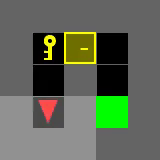

In [13]:
gym_simulation(MINIGRID_ENV, agent_a2c, wrappers=[minigrid_wrapper])

## Random Network Distillation

RND encourages the agent to visit unfamiliar states. It measures novelty by seeing how accurately a
_predictor_ network can guess the output of a _fixed, randomly initialized target network_ given the
current state.

 * **Familiar states:** The predictor network learns to accurately predict the target's output.
   Prediction error is low -> low intrinsic reward (boredom).
 * **Novel states:** The predictor network struggles to predict the target's output. Prediction
   error is high -> high intrinsic reward (curiosity).

This intrinsic reward motivates the agent to explore parts of the environment it hasn't seen often,
helping it overcome sparse extrinsic rewards and learn more effectively. RND cleverly avoids issues
found in other intrinsic motivation methods (like getting distracted by unpredictable but irrelevant
things, e.g., a noisy TV screen).

### RND Module

Let's implement the RND module, i.e., the neural network used to output the instrinsic reward using
a trainable predictor and a fixed target network.

In [10]:
class RNDModule(nn.Module):
    def __init__(self, hidden_dim=256):
        super(RNDModule, self).__init__()
        # RND predictor network.
        self.predictor = nn.Sequential(
            convolutional_embedding(),
            nn.Linear(1024, hidden_dim),
            # Extra layers in predictor, regularized via dropouts.
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        # RND target network (non-trainable)
        self.target = nn.Sequential(
            convolutional_embedding(),
            nn.Linear(1024, hidden_dim),
        )
        # Freeze the target network
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, obs):
        target_output = self.target(obs).detach()
        predictor_output = self.predictor(obs)
        # Intrinsic reward for each step of the trajectory.
        rnd_error = F.mse_loss(target_output.detach(), predictor_output, reduction='none').mean(-1)
        return rnd_error

### A2C w/ RND

Let's now re-implement A2C integrating RND and intrinsic rewards.

In [11]:
class AgentA2CWithRND(BaseAgent):
    def __init__(self, env, gamma=0.99, lr=0.0001,
                 vloss_coeff=0.5, ent_coeff=0.01, max_grad_norm_ac=0.5,
                 # The following hyperparameters have been tuned for minigrid in these examples.
                 gamma_rnd=0.99, eta_extr=100., eta_intr=10., max_grad_norm_rnd=0.01):
        self.env = env
        self.gamma = gamma
        self.vloss_coeff = vloss_coeff
        self.ent_coeff = ent_coeff
        self.max_grad_norm_ac = max_grad_norm_ac
        self.gamma_rnd = gamma_rnd
        self.eta_extr = eta_extr
        self.eta_intr = eta_intr
        self.max_grad_norm_rnd = max_grad_norm_rnd

        self.model = ActorCritic(env.action_space[0].n).to(DEVICE)
        self.rnd_module = RNDModule().to(DEVICE)
        self.optimizer = optim.RMSprop(list(self.model.parameters()) +
                                       list(self.rnd_module.predictor.parameters()), lr=lr)

    @torch.no_grad
    def eval(self, obs: torch.Tensor) -> tuple[torch.Tensor, ...]:
        obs            = obs.permute(0, 3, 1, 2)
        dist, values   = self.model(obs)
        action         = dist.sample()
        return action, dist.log_prob(action), values

    def learn(self, segment: TrajectorySegment) -> dict:
        batch_size = segment.obs.shape[0]
        n_envs     = segment.obs.shape[1]

        with torch.no_grad():
            _, _, next_values = self.eval(segment.next_start_obs)
            advantages_extr, returns_extr = \
                compute_advantages_and_returns(segment.rewards, segment.dones,
                                               segment.values[:, :, 0], next_values[:, 0],
                                               gamma=self.gamma)
            next_obs        = segment.next_obs().flatten(0, 1).permute(0, 3, 1, 2)
            self.rnd_module.eval()
            # In the original implementation, the intrinsic rewards are scaled by a rolling std.
            intr_rewards    = self.rnd_module(next_obs).reshape(batch_size, n_envs)
            self.rnd_module.train()
            advantages_intr, returns_intr = \
                compute_advantages_and_returns(intr_rewards, segment.dones, segment.values[:, :, 1],
                                               next_values[:, 1], gamma=self.gamma_rnd)

        # Flatten and shuffle observations from all environments.
        obs, actions, advantages_extr, returns_extr = flatten_and_shuffle(
            segment.obs.permute(0, 1, 4, 2, 3), segment.actions, advantages_extr, returns_extr)
        advantages_intr, returns_intr = flatten_and_shuffle(advantages_intr, returns_intr)

        # Compute advantages as combination of extrinsic and intrinsic.
        advantages      = advantages_extr * self.eta_extr + advantages_intr * self.eta_intr

        # Forward pass
        dist, values    = self.model(obs)
        logprobs        = dist.log_prob(actions)
        entropy         = dist.entropy().mean()

        # AC Loss
        policy_loss      = -(logprobs * advantages).mean()
        value_extr_loss  = F.mse_loss(values[:, 0], returns_extr)
        value_intr_loss  = F.mse_loss(values[:, 1], returns_intr)
        value_loss       = value_extr_loss + value_intr_loss

        # RND. In the original implementation, observations are normalized here.
        # Moreover, there is a masked update on the number of experience for regularization
        # (which we don't do and use dropouts instead).
        rnd_error = self.rnd_module(obs)
        rnd_loss  = rnd_error.mean()

        # Total loss
        loss = policy_loss + value_loss * self.vloss_coeff - entropy * self.ent_coeff + rnd_loss

        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm_ac)
        nn.utils.clip_grad_norm_(self.rnd_module.predictor.parameters(), self.max_grad_norm_rnd)
        self.optimizer.step()

        return {
            "loss": loss.item(),
            "rnd_reward_avg": intr_rewards.mean().item(),
            "rnd_loss": rnd_loss.item(),
        }

### Let's train A2C w/ RND on a trivial grid

In [17]:
env = init_random(make_minigrid_env())
agent_rnd = AgentA2CWithRND(env)
train(env, agent_rnd, solved_score=0.91)

Global step: 1600, Average Score: 0.15748                                                           
Global step: 3200, Average Score: 0.31738                                                           
Global step: 4800, Average Score: 0.47019                                                           
Global step: 6400, Average Score: 0.73292                                                           
Global step: 8000, Average Score: 0.79752                                                           
Global step: 9600, Average Score: 0.89236                                                           
Global step: 11200, Average Score: 0.92271                                                          
Environment solved with avg_score: 0.92271                                                          


MoviePy - Building file /tmp/rl-video.gif with imageio.


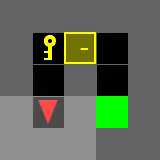

In [18]:
gym_simulation(MINIGRID_ENV, agent_rnd, wrappers=[minigrid_wrapper])

## Time to shine: larger grids!

Let's train our A2C w/ RND on a larger grid.

### MiniGrid-DoorKey-8x8

In [20]:
env = init_random(make_minigrid_env(MINIGRID_ENV_8x8))
agent_rnd_8 = AgentA2CWithRND(env)
train(env, agent_rnd_8)

Global step: 1600, Average Score: 0.01997                                                           
Global step: 3200, Average Score: 0.01882                                                           
Global step: 4800, Average Score: 0.01663                                                           
Global step: 6400, Average Score: 0.03821                                                           
Global step: 8000, Average Score: 0.04878                                                           
Global step: 9600, Average Score: 0.01358                                                           
Global step: 11200, Average Score: 0.03638                                                          
Global step: 12800, Average Score: 0.05024                                                          
Global step: 14400, Average Score: 0.05824                                                          
Global step: 16000, Average Score: 0.08342                                                 

MoviePy - Building file /tmp/rl-video.gif with imageio.


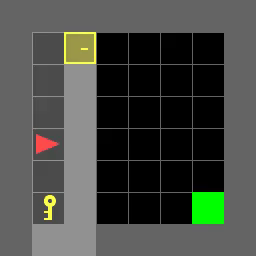

In [21]:
gym_simulation(MINIGRID_ENV_8x8, agent_rnd_8, wrappers=[minigrid_wrapper])

Now let's train just A2C, giving it some benefits with lower solved score threshold :)

In [22]:
env = init_random(make_minigrid_env(MINIGRID_ENV_8x8))
agent_a2c_8 = AgentA2C(env)
# Give A2C some benefits, and reduce the threshold for solved score :)
train(env, agent_a2c_8, solved_score=0.91)

Global step: 1600, Average Score: 0.00699                                                           
Global step: 3200, Average Score: 0.00809                                                           
Global step: 4800, Average Score: 0.00827                                                           
Global step: 6400, Average Score: 0.00912                                                           
Global step: 8000, Average Score: 0.01158                                                           
Global step: 9600, Average Score: 0.00817                                                           
Global step: 11200, Average Score: 0.00153                                                          
Global step: 12800, Average Score: 0.00564                                                          
Global step: 14400, Average Score: 0.00765                                                          
Global step: 16000, Average Score: 0.00404                                                 

MoviePy - Building file /tmp/rl-video.gif with imageio.


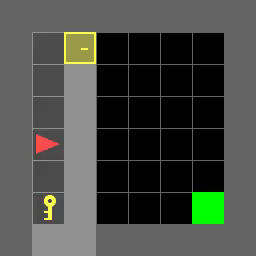

In [23]:
gym_simulation(MINIGRID_ENV_8x8, agent_a2c_8, wrappers=[minigrid_wrapper])

### MiniGrid-DoorKey-16x16

Train A2C w/ RND on `MiniGrid-DoorKey-16x16`. It is going to take time, b/c lots of exploration is
required before getting stable reward signals... but it will be solved!

NOTE: This is computationally really intensive (128 parallel env)! Consider just running the
pretrained simulation below.

In [ ]:
def run_pretrained_simulation():
    loaded_env = gym.make_vec(MINIGRID_ENV_16x16, wrappers=[minigrid_wrapper])
    loaded_agent = AgentA2CWithRND(loaded_env)
    loaded_params = torch.load('solution/a2c_rnd_16x16_weights.pth', map_location=DEVICE)
    loaded_agent.model.load_state_dict(loaded_params['a2c_params'])
    loaded_agent.rnd_module.load_state_dict(loaded_params['rnd_params'])

    return gym_simulation(MINIGRID_ENV_16x16, loaded_agent, wrappers=[minigrid_wrapper], seed=110)

# Uncomment the following line to run the pretrained agent on the 16x16 grid.
# run_pretrained_simulation()

In [12]:
env = init_random(make_minigrid_env(MINIGRID_ENV_16x16, num_envs=128))
agent_rnd_16 =AgentA2CWithRND(env, gamma=0.995)
train(env, agent_rnd_16, rollout_size=48, log_every=35)

Global step: 1680, Average Score: nan                                                               
Global step: 3360, Average Score: 0.00000                                                           
Global step: 5040, Average Score: 0.00000                                                           
Global step: 6720, Average Score: 0.00000                                                           
Global step: 8400, Average Score: 0.00000                                                           
Global step: 10080, Average Score: 0.00342                                                          
Global step: 11760, Average Score: 0.00000                                                          
Global step: 13440, Average Score: 0.00000                                                          
Global step: 15120, Average Score: 0.00250                                                          
Global step: 16800, Average Score: 0.00576                                                 

MoviePy - Building file /tmp/rl-video.gif with imageio.


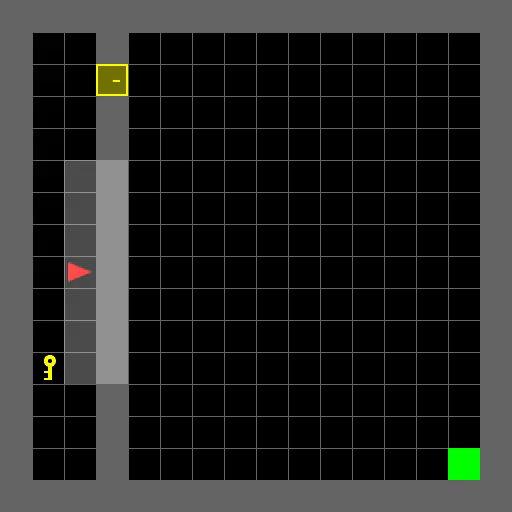

In [16]:
gym_simulation(MINIGRID_ENV_16x16, agent_rnd_16, wrappers=[minigrid_wrapper])

Feel free to try A2C on the same environment... wait as much as you like... but I would
not recommend staying too long :)

In [ ]:
# Attempt bare A2C... it's not gonna work...
env = init_random(make_minigrid_env(MINIGRID_ENV_16x16, num_envs=128))
agent_a2c_16 =AgentA2C(env, gamma=0.995)
train(env, agent_a2c_16, rollout_size=48, log_every=35, solved_score=0.91)

Global step: 1680, Average Score: nan                                                                                                                                                                                                                                                                                                                         
Global step: 3360, Average Score: 0.0000                                                                                                                                                                                                                                                                                                                      
Global step: 5040, Average Score: 0.0053                                                                                                                                                                                                                                                                  

KeyboardInterrupt: 